### Investigation: RX($\phi$) with correlated CRX($\gamma \phi$) noise on the circuit-level with ideal hyperparameters

In [1]:
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from correlated_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context,
    circuit_gate_times,
    phi,
    gamma
)
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from helper_functions import load_from_yaml_file
from gymnasium.spaces import Box
from gymnasium.wrappers import RescaleAction, ClipAction
from helper_functions import get_baseline_fid_from_phi_gamma


import logging

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s INFO %(message)s",  # hardcoded INFO level
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
     ┌─────────────────────────────┐     
q_0: ┤0                            ├──■──
     │  custom_kron(rx,ident)_gate │┌─┴─┐
q_1: ┤1                            ├┤ X ├
     └─────────────────────────────┘└───┘


/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
gate_q_env_config.action_space

Box(-3.14, 3.14, (7,), float32)

In [3]:
q_env = ContextAwareQuantumEnvironment(gate_q_env_config, circuit_context)
q_env = ClipAction(q_env)
q_env = RescaleAction(q_env, -1.0, 1.0)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [4]:
q_env.action_space

Box(-1.0, 1.0, (7,), float32)

In [5]:
q_env.unwrapped.backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.circuit_truncations to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.circuit_truncations` for environment variables or `env.get_wrapper_attr('circuit_truncations')` that will search the reminding wrappers.
  logger.warn(


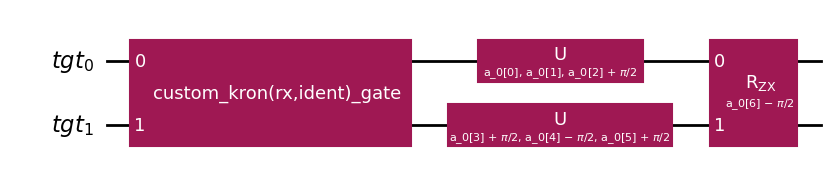

In [6]:
q_env.circuit_truncations[0].draw("mpl")

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.baseline_truncations to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.baseline_truncations` for environment variables or `env.get_wrapper_attr('baseline_truncations')` that will search the reminding wrappers.
  logger.warn(


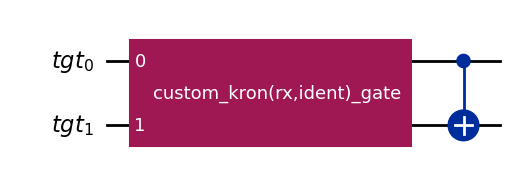

In [7]:
q_env.baseline_truncations[0].draw("mpl")

##### Baseline-Gate Fidelities with respective noise applied

In [8]:
print(f'phi = {phi/np.pi}pi; gamma = {gamma}')

phi = 0.25pi; gamma = 0.02


In [9]:
gamma * phi

0.015707963267948967

In [10]:
baseline_fidelity = get_baseline_fid_from_phi_gamma((phi, gamma))
baseline_fidelity

0.9999383162408302

In [11]:
from ppo_while_not_met_baseline import make_train_ppo
from itertools import product
import math

In [12]:
def get_min_and_max_N_REPS(target_fidelities, phi_gamma_tuple):
    baseline_fidelity = get_baseline_fid_from_phi_gamma(phi_gamma_tuple)
    min_n_reps = math.ceil(math.log(min(target_fidelities), baseline_fidelity))
    # Ensure that the number of repetitions is not too large in order to not exceed the rotation of pi (due to the periodicity of the Bloch sphere)
    while min_n_reps * np.prod(phi_gamma_tuple) > np.pi:
        min_n_reps -= 1

    max_n_reps = 0
    while max_n_reps * np.prod(phi_gamma_tuple) < np.pi:
        max_n_reps += 1
    return (min_n_reps, max_n_reps)

In [13]:
max_runtime = 1_200
lookback_window = 10

target_fidelities = [0.999, 0.9999, 0.99999]

min_n_reps, max_n_reps = get_min_and_max_N_REPS(target_fidelities, phi_gamma_tuple=(phi, gamma))
min_n_reps

17

In [14]:
max_n_reps

200

In [15]:
# q_env.unwrapped.n_reps = 5 # int(max_n_reps / 8)
q_env.unwrapped.n_reps

1

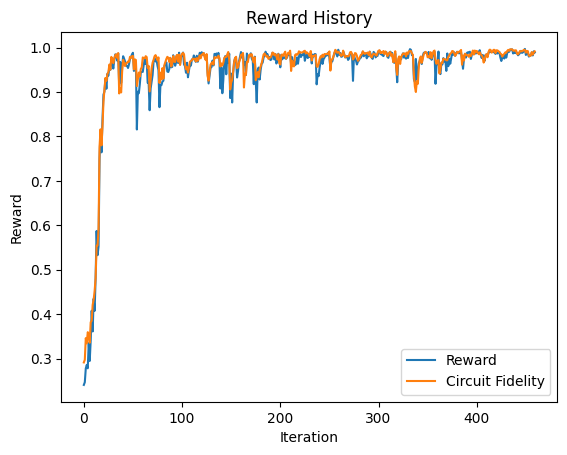

probabilities renormalized
Fidelity stored 0.9865652420081867
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'XY', 'YI', 'YZ', 'ZX'],
              coeffs=[ 1.        +0.j,  1.41421356+0.j, -1.41421356+0.j,  1.41421356+0.j,
  1.        +0.j,  1.41421356+0.j])
Finished Estimator job
mean tensor([ 0.0066, -0.3501,  0.3872, -0.0115,  0.0273, -0.0089, -0.0227])
sigma tensor([0.0317, 0.0322, 0.0220, 0.0284, 0.0281, 0.0308, 0.0205])
DFE Rewards Mean: 0.986547034578292
DFE Rewards standard dev 0.031443680696061065
Returns Mean: 7.1156955
Returns standard dev: 4.731619
Advantages Mean: -0.11156306
Advantages standard dev 4.7316194
Total Updates applied: 461
Total Shots applied: 53,376,000
probabilities renormalized
Fidelity stored 0.9918225219000305
Sending Estimator job...
SparsePauliOp(['II', 'XX', 'YZ', 'ZY'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
Finished Estimator job
mean tensor([-0.0099, -0.3602,  0.3684, -0.0035,  0.0035, -0.0269, -0.0194])
sigma tensor([0.0257, 0

In [16]:
agent_config = load_from_yaml_file('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')

train_agent = make_train_ppo(agent_config, q_env)

training_results = train_agent(
    target_fidelities=target_fidelities, 
    lookback_window=lookback_window,
    plot_real_time=True,
    std_actions_eps=1e-3,
    max_runtime=max_runtime,
    print_debug=True,
    num_prints=5
)

In [17]:
max(training_results['fidelity_history'])

0.9961246629311938

In [18]:
q_env.unwrapped.optimal_action[3]

-0.06385966204106808

In [19]:
gamma * phi

0.015707963267948967

Final Fidelity: 0.9918225219000305


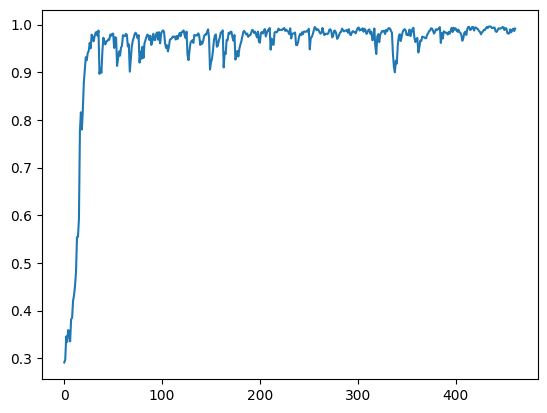

In [20]:
print('Final Fidelity:', training_results['fidelity_history'][-1])
plt.plot(training_results['fidelity_history'])

In [21]:
training_results['best_action_vector']

array([ 0.00336057, -1.14588245,  1.11305944, -0.06385966,  0.01841897,
       -0.09910262,  0.06587915])

In [22]:
training_results['fidelity_info']

{0.999: {'achieved': False,
  'update_at': None,
  'train_time': None,
  'shots_used': None},
 0.9999: {'achieved': False,
  'update_at': None,
  'train_time': None,
  'shots_used': None},
 0.99999: {'achieved': False,
  'update_at': None,
  'train_time': None,
  'shots_used': None}}

In [23]:
max(training_results['fidelity_history'])

0.9961246629311938

In [24]:
sum(training_results['total_shots'])

53544960

In [25]:
if training_results['exceeded_baseline_fidelity']:

    file_name = f'training_results_with_beaten_baseline_phi_{phi_file_name_mapping[phi]}_gamma_{gamma}.pickle'
    dir_name = f'exceeded_gate_baseline_fidelity_results_max{round(max_runtime/60, 0)}min'
    comb_path = os.path.join(dir_name, file_name)

    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    with open(comb_path, 'wb') as handle:
        pickle.dump(training_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

KeyError: 'exceeded_baseline_fidelity'